Prerequisites:

In [1]:
import pandas as pd
import numpy as np
import sktime
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sktime.forecasting.model_selection import  temporal_train_test_split ,SlidingWindowSplitter
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import make_reduction
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.forecasting.model_selection import ForecastingGridSearchCV

# Pipelines
from sktime.forecasting.compose import TransformedTargetForecaster,MultiplexForecaster
from sktime.pipeline import make_pipeline
from sktime.forecasting.compose import EnsembleForecaster
from sktime.forecasting.compose import AutoEnsembleForecaster

# Transformers and forecasters:
from sktime.transformations.series.detrend import Deseasonalizer ,Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.transformations.series.impute import Imputer
from sktime.forecasting.naive import NaiveForecaster

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression,Ridge

## 1. Data preparation:

In [2]:
df = pd.read_csv("monthly_beer.csv")
y = df["Monthly beer production"]
y.index = pd.date_range("1956-01", freq="M", periods=476)
y.index = y.index.to_period()
y

1956-01     93.2
1956-02     96.0
1956-03     95.2
1956-04     77.1
1956-05     70.9
           ...  
1995-04    127.0
1995-05    151.0
1995-06    130.0
1995-07    119.0
1995-08    153.0
Freq: M, Name: Monthly beer production, Length: 476, dtype: float64

Train-Test split:

In [3]:
y_train , y_test = temporal_train_test_split(y , test_size=48 )
fh = ForecastingHorizon(y_test.index, is_relative=False)

Cross validation set:

In [4]:
# defining our splits for cross validation:
cv = SlidingWindowSplitter( window_length=50, step_length=5) #  window_length=20 , initial_window=int(len(y_train) * 0.8)

# cut-off points in series
cv.get_cutoffs(y_train)

array([ 49,  54,  59,  64,  69,  74,  79,  84,  89,  94,  99, 104, 109,
       114, 119, 124, 129, 134, 139, 144, 149, 154, 159, 164, 169, 174,
       179, 184, 189, 194, 199, 204, 209, 214, 219, 224, 229, 234, 239,
       244, 249, 254, 259, 264, 269, 274, 279, 284, 289, 294, 299, 304,
       309, 314, 319, 324, 329, 334, 339, 344, 349, 354, 359, 364, 369,
       374, 379, 384, 389, 394, 399, 404, 409, 414, 419, 424], dtype=int64)

## 2. Hyperparameter tuning:

#### Optimization steps:

* Regressor and forecaster are defined, also the strategy.
* In a dictionary, the parameters and their values are listed for optimization task. 
* A parameter should be named as it is if, it is a forecaster parameter. If it is a regressor parameter "estimator__" should be added in front of the word. 
* Grid search object is created with the needed inputs and fitted to the training set.


In [5]:
regressor = Ridge()
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")

# The parameters and their values:
param_grid = {"window_length": [7, 12, 15] , 
              
              # Regressor parameters:
              "estimator__alpha": [0.1,1,10],
              "estimator__fit_intercept": [True,False]
             
             }

# Grid searc begins:
gscv = ForecastingGridSearchCV( forecaster, strategy="refit", cv=cv, param_grid=param_grid )
gscv.fit(y_train)

ForecastingGridSearchCV(cv=SlidingWindowSplitter(step_length=5, window_length=50),
                        forecaster=RecursiveTabularRegressionForecaster(estimator=Ridge(),
                                                                        window_length=15),
                        param_grid={'estimator__alpha': [0.1, 1, 10],
                                    'estimator__fit_intercept': [True, False],
                                    'window_length': [7, 12, 15]})

In [6]:
# Grid search parameters that can be optimized:
forecaster.get_params()

{'estimator__alpha': 1.0,
 'estimator__copy_X': True,
 'estimator__fit_intercept': True,
 'estimator__max_iter': None,
 'estimator__normalize': 'deprecated',
 'estimator__positive': False,
 'estimator__random_state': None,
 'estimator__solver': 'auto',
 'estimator__tol': 0.001,
 'estimator': Ridge(),
 'transformers': None,
 'window_length': 15}

In [7]:
# After the grid search, the best parameters:
gscv.best_forecaster_

RecursiveTabularRegressionForecaster(estimator=Ridge(alpha=10,
                                                     fit_intercept=False),
                                     window_length=12)

Mean Absolute Percentage Error: % 10.271934848754928


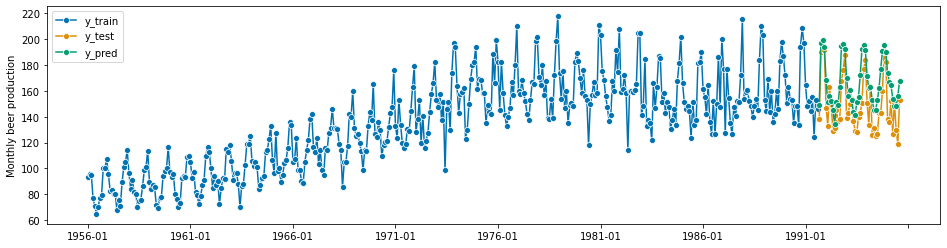

In [8]:
# Test result:
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print("Mean Absolute Percentage Error: %" , 100*mean_absolute_percentage_error(y_pred , y_test))

## 3. Pipelines in sktime:

Pipelining the forecasting task with multiple steps can be useful and time saving. The pipelining in sktime is similar to sklearn and also compatible.

### 3.1 TransformedTargetForecaster:

For a forecasting task with transformations, TransformedTargetForecaster could be used.

Mean Absolute Percentage Error: % 6.346176621446929


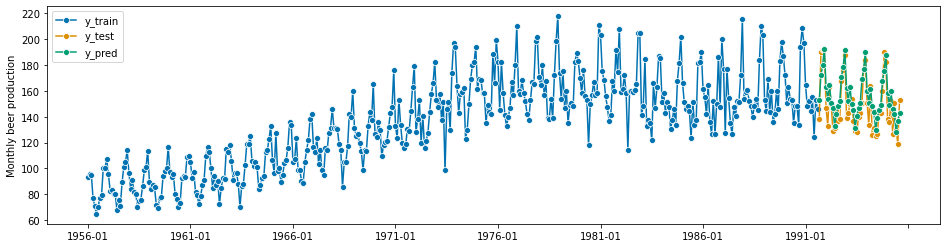

In [9]:
# The pipeline:
forecaster = TransformedTargetForecaster(
    [
        # Steps:
        ("imputer", Imputer(method="mean")),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=2))),
        ("deseasonalize", Deseasonalizer(model="additive", sp=12)),
        ("forecast", ExponentialSmoothing()),
    ]
)

# Trainig and testing:
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print("Mean Absolute Percentage Error: %" , 100*mean_absolute_percentage_error(y_pred , y_test))

In [10]:
# The hyperparameters can be tuned with the following namings:
forecaster.get_params()

{'steps': [('imputer', Imputer(method='mean')),
  ('detrend', Detrender(forecaster=PolynomialTrendForecaster(degree=2))),
  ('deseasonalize', Deseasonalizer(sp=12)),
  ('forecast', ExponentialSmoothing())],
 'imputer': Imputer(method='mean'),
 'detrend': Detrender(forecaster=PolynomialTrendForecaster(degree=2)),
 'deseasonalize': Deseasonalizer(sp=12),
 'forecast': ExponentialSmoothing(),
 'imputer__forecaster': None,
 'imputer__method': 'mean',
 'imputer__missing_values': None,
 'imputer__random_state': None,
 'imputer__value': None,
 'detrend__forecaster__degree': 2,
 'detrend__forecaster__regressor': None,
 'detrend__forecaster__with_intercept': True,
 'detrend__forecaster': PolynomialTrendForecaster(degree=2),
 'deseasonalize__model': 'additive',
 'deseasonalize__sp': 12,
 'forecast__damped_trend': False,
 'forecast__damping_trend': None,
 'forecast__initial_level': None,
 'forecast__initial_seasonal': None,
 'forecast__initial_trend': None,
 'forecast__initialization_method': 'est

### 3.2 MultiplexForecaster:

This pipeline composition finds the best algorithm from the forecasters:

In [11]:
# The pipeline:
forecaster = MultiplexForecaster(
    
    forecasters=[
        # forecasters defined:
        ("naive", NaiveForecaster(strategy="drift")),
        ("ets", ExponentialSmoothing(trend='add', seasonal='multiplicative', sp=12)),
        ( "trend" , PolynomialTrendForecaster())
    ],
)

# Forecaster names as parameters:
forecaster_param_grid = {"selected_forecaster": ["ets", "naive","trend"]}

# Forecasters will be tested on the cross validation set and the best one will be choosen.
cv = SlidingWindowSplitter( window_length=50, step_length=5)
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=forecaster_param_grid)
gscv.fit(y_train)

ForecastingGridSearchCV(cv=SlidingWindowSplitter(step_length=5, window_length=50),
                        forecaster=MultiplexForecaster(forecasters=[('naive',
                                                                     NaiveForecaster(strategy='drift')),
                                                                    ('ets',
                                                                     ExponentialSmoothing(seasonal='multiplicative',
                                                                                          sp=12,
                                                                                          trend='add')),
                                                                    ('trend',
                                                                     PolynomialTrendForecaster())]),
                        param_grid={'selected_forecaster': ['ets', 'naive',
                                                            'trend']})

In [12]:
# Best forecaster:
gscv.best_forecaster_

MultiplexForecaster(forecasters=[('naive', NaiveForecaster(strategy='drift')),
                                 ('ets',
                                  ExponentialSmoothing(seasonal='multiplicative',
                                                       sp=12, trend='add')),
                                 ('trend', PolynomialTrendForecaster())],
                    selected_forecaster='ets')

Mean Absolute Percentage Error: % 8.071932255371122


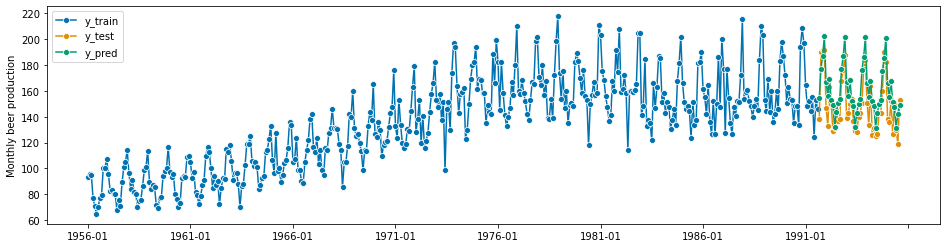

In [13]:
# Test result:
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print("Mean Absolute Percentage Error: %" , 100*mean_absolute_percentage_error(y_pred , y_test))

## 4. Ensemble Forecasting:
Ensemble forecaster uses multiple forecasters and aggregates them to come up with a single solution.

In [14]:
from sktime.transformations.series.detrend import Detrender , Deseasonalizer
from sktime.forecasting.trend import TrendForecaster,PolynomialTrendForecaster

# Combining and aggregating multiple forecasts

forecaster_1 = ExponentialSmoothing(trend='add', seasonal='additive', sp=12)
forecaster_2 = PolynomialTrendForecaster(degree=2)

ses = ExponentialSmoothing(sp=12)
holt = ExponentialSmoothing(trend="add", damped_trend=False, sp=12)
damped = ExponentialSmoothing(trend="add", damped_trend=True, sp=12)

forecaster = EnsembleForecaster(
    [
        # forecasters:
        ("Exponential_Smoothing", forecaster_1),
        ("Detrender", forecaster_2  ),
        
    ]
    
    # aggregating function:
    , aggfunc="mean" # "median"
)

forecaster.fit(y_train)


EnsembleForecaster(forecasters=[('Exponential_Smoothing',
                                 ExponentialSmoothing(seasonal='additive',
                                                      sp=12, trend='add')),
                                ('Detrender',
                                 PolynomialTrendForecaster(degree=2))])

Mean Absolute Percentage Error: % 8.768969487130821


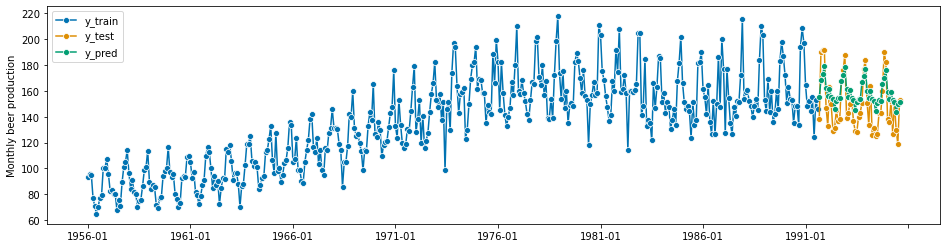

In [15]:
# Test result:
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print("Mean Absolute Percentage Error: %" , 100*mean_absolute_percentage_error(y_pred , y_test))

### 4.1 AutoEnsembleForecaster:
Automatically find best weights for the ensembled forecasters.

In [16]:
forecasters = [
        ("ets", ExponentialSmoothing(trend='add', seasonal='additive', sp=12)),
        ("detren", PolynomialTrendForecaster(degree=2)  ),
]
forecaster = AutoEnsembleForecaster(forecasters=forecasters)
forecaster.fit(y=y_train)

AutoEnsembleForecaster(forecasters=[('ets',
                                     ExponentialSmoothing(seasonal='additive',
                                                          sp=12, trend='add')),
                                    ('detren',
                                     PolynomialTrendForecaster(degree=2))])

Mean Absolute Percentage Error: % 7.977783761072375


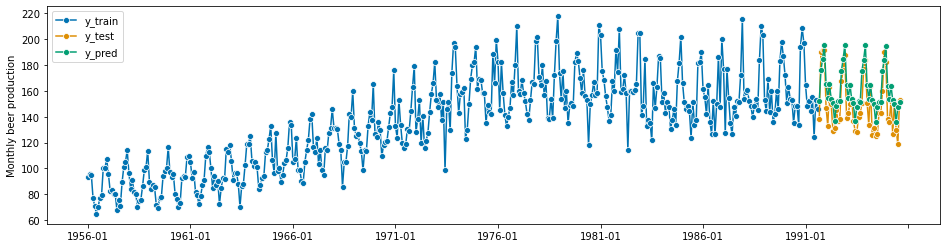

In [17]:
y_pred = forecaster.predict(fh=fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print("Mean Absolute Percentage Error: %" , 100*mean_absolute_percentage_error(y_pred , y_test))

In [18]:
print( "Weight of the Exponential Smoothing forecaster:" ,forecaster.weights_[0])
print( "Weight of the Trend forecaster:" ,forecaster.weights_[1])

Weight of the Exponential Smoothing forecaster: 0.9095140809934343
Weight of the Trend forecaster: 0.0904859190065656


Bonus: Giving an exogenous data to forecaster

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Monthly beer production'>)

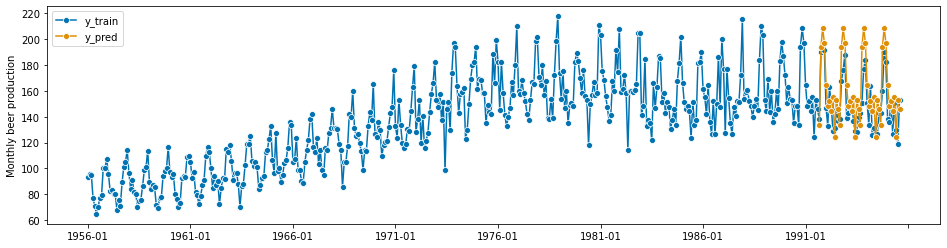

In [19]:
# dummy X variable
X = pd.DataFrame( y_train.index.month ,index=y_train.index ) 

forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train, X=X , fh=fh)

y_pred = forecaster.predict(X=X)
plot_series(y, y_pred, labels=["y_train", "y_pred"])